In [1]:
%matplotlib qt

In [2]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

def average_FFT_spectrum(input_data, sampling_frequency, tmin = 0):
    K,N = np.shape(input_data)                       # Get the number of trials, and number of pts per trial.
    dt = 1.0 / sampling_frequency
    t = np.linspace(0, N, num = N, endpoint=False) * dt + tmin
    T = N * dt                                        # Get the total duration of the recording.
    Sxx = np.zeros([K,int(N/2+1)])		              # Create variable to store each spectrum.
    for k,x in enumerate(input_data):				          # For each trial,
        xf  = np.fft.rfft(x-np.mean(x)) 	          # ... compute the Fourier transform,
        Sxx[k,:] = 2*dt**2/T *np.real(xf*np.conj(xf)) # ... and compute the spectrum.
        pass
    f = np.fft.rfftfreq(N, dt)                        # Define a frequency axis
    return Sxx, f, t

def CrossCoherence(input_data1, input_data2, sampling_frequency):
    K,N = np.shape(input_data1)                       # Get the number of trials, and number of pts per trial.
    dt = 1.0 / sampling_frequency
    T = N * dt                                        # Get the total duration of the recording.
    Sxx = np.zeros([K,int(N/2+1)])		              # Create variables to save the spectra,
    Syy = np.zeros([K,int(N/2+1)])
    Sxy = np.zeros([K,int(N/2+1)], dtype=complex)
    for k in range(K):			                      # For each trial,
        x=input_data1[k,:]
        y=input_data2[k,:]
        xf  = np.fft.rfft(x-np.mean(x))               # ... compute Fourier transform,
        yf  = np.fft.rfft(y-np.mean(y))
        Sxx[k,:] = 2*dt**2/T *np.real(xf*np.conj(xf)) # ... and compute the spectra.
        Syy[k,:] = 2*dt**2/T *np.real(yf*np.conj(yf))
        Sxy[k,:] = 2*dt**2/T *       (xf*np.conj(yf))
        pass
    SxxM = np.mean(Sxx,0)		                      # Average the spectra across trials,
    SyyM = np.mean(Syy,0)
    SxyM = np.mean(Sxy,0)
    f = np.fft.rfftfreq(N, dt)                        # Define a frequency axis   
    cohr = np.abs(SxyM) / (np.sqrt(SxxM) * np.sqrt(SyyM))# ... and compute the coherence.
    return cohr, Sxy, f

def get_phase_difference_at_frequency(Sxy, f, f_value):
    K = Sxy.shape[0]
    f_loc = np.where(f==f_value)[0][0]	 # Determine index j for frequency 8 Hz.
    phi = np.angle(Sxy[:, f_loc])
    return phi


In [3]:
#filename = "close eyes 2min_07.08.20_20.13.36.md.csv"
filename = "eye close_31.08.20_14.09.53.md.csv"
df = pd.read_csv(filename,skiprows=1)
df.head(10)


,Timestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,...,MOT.InterpolatedMems,MOT.GyroX,MOT.GyroY,MOT.GyroZ,MOT.AccX,MOT.AccY,MOT.AccZ,MOT.MagX,MOT.MagY,MOT.MagZ
0,1.598854e+09,108.0,0.0,4210.256348,4220.128418,4242.436035,4278.974121,4217.692383,4228.205078,4233.589844,...,0.0,8221.0,8127.0,8214.0,4204.0,8462.0,7684.0,8500.0,7948.0,7718.0
1,1.598854e+09,109.0,0.0,4223.461426,4221.153809,4248.205078,4280.256348,4216.666504,4221.282227,4230.384766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.598854e+09,110.0,0.0,4230.256348,4228.717773,4254.743652,4285.769043,4216.538574,4215.384766,4228.077148,...,0.0,8215.0,8140.0,8214.0,4216.0,8443.0,7690.0,8503.0,7950.0,7719.0
3,1.598854e+09,111.0,0.0,4227.436035,4232.051270,4255.897461,4284.615234,4215.641113,4214.487305,4219.102539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.598854e+09,112.0,0.0,4225.000000,4231.282227,4256.538574,4278.846191,4214.487305,4213.589844,4208.205078,...,0.0,8215.0,8149.0,8209.0,4211.0,8428.0,7714.0,8504.0,7953.0,7717.0
5,1.598854e+09,113.0,0.0,4221.666504,4234.230957,4258.717773,4280.000000,4218.077148,4215.641113,4208.974121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.598854e+09,114.0,0.0,4212.436035,4232.179688,4248.333496,4278.974121,4218.717773,4217.436035,4220.256348,...,0.0,8208.0,8144.0,8206.0,4213.0,8438.0,7722.0,8508.0,7948.0,7716.0
7,1.598854e+09,115.0,0.0,4203.589844,4219.102539,4231.922852,4268.205078,4214.487305,4218.589844,4232.692383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.598854e+09,116.0,0.0,4199.487305,4209.615234,4236.410156,4258.846191,4215.641113,4221.538574,4237.051270,...,0.0,8212.0,8145.0,8206.0,4220.0,8428.0,7738.0,8504.0,7960.0,7719.0
9,1.598854e+09,117.0,0.0,4202.436035,4213.974121,4257.051270,4260.897461,4218.846191,4221.025879,4235.641113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
EEG_df = df.ix[:, 'EEG.AF3':'EEG.AF4']
EEG_df = EEG_df - EEG_df.mean()

ch_name=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Sampling rate of the Nautilus machine
sfreq = 128  # Hz

# Create the info structure needed by MNE
info = mne.create_info(ch_name, sfreq,ch_types ='eeg')

# Finally, create the Raw object
raw = mne.io.RawArray(np.transpose(np.array(EEG_df)), info)

# Plot it!
raw.plot(scalings= {'eeg':100})
raw.plot_sensors()

Creating RawArray with float64 data, n_channels=14, n_times=16028
    Range : 0 ... 16027 =      0.000 ...   125.211 secs
Ready.


/Users/kevinhsu/anaconda3/envs/mne17/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


RuntimeError: No valid channel positions found

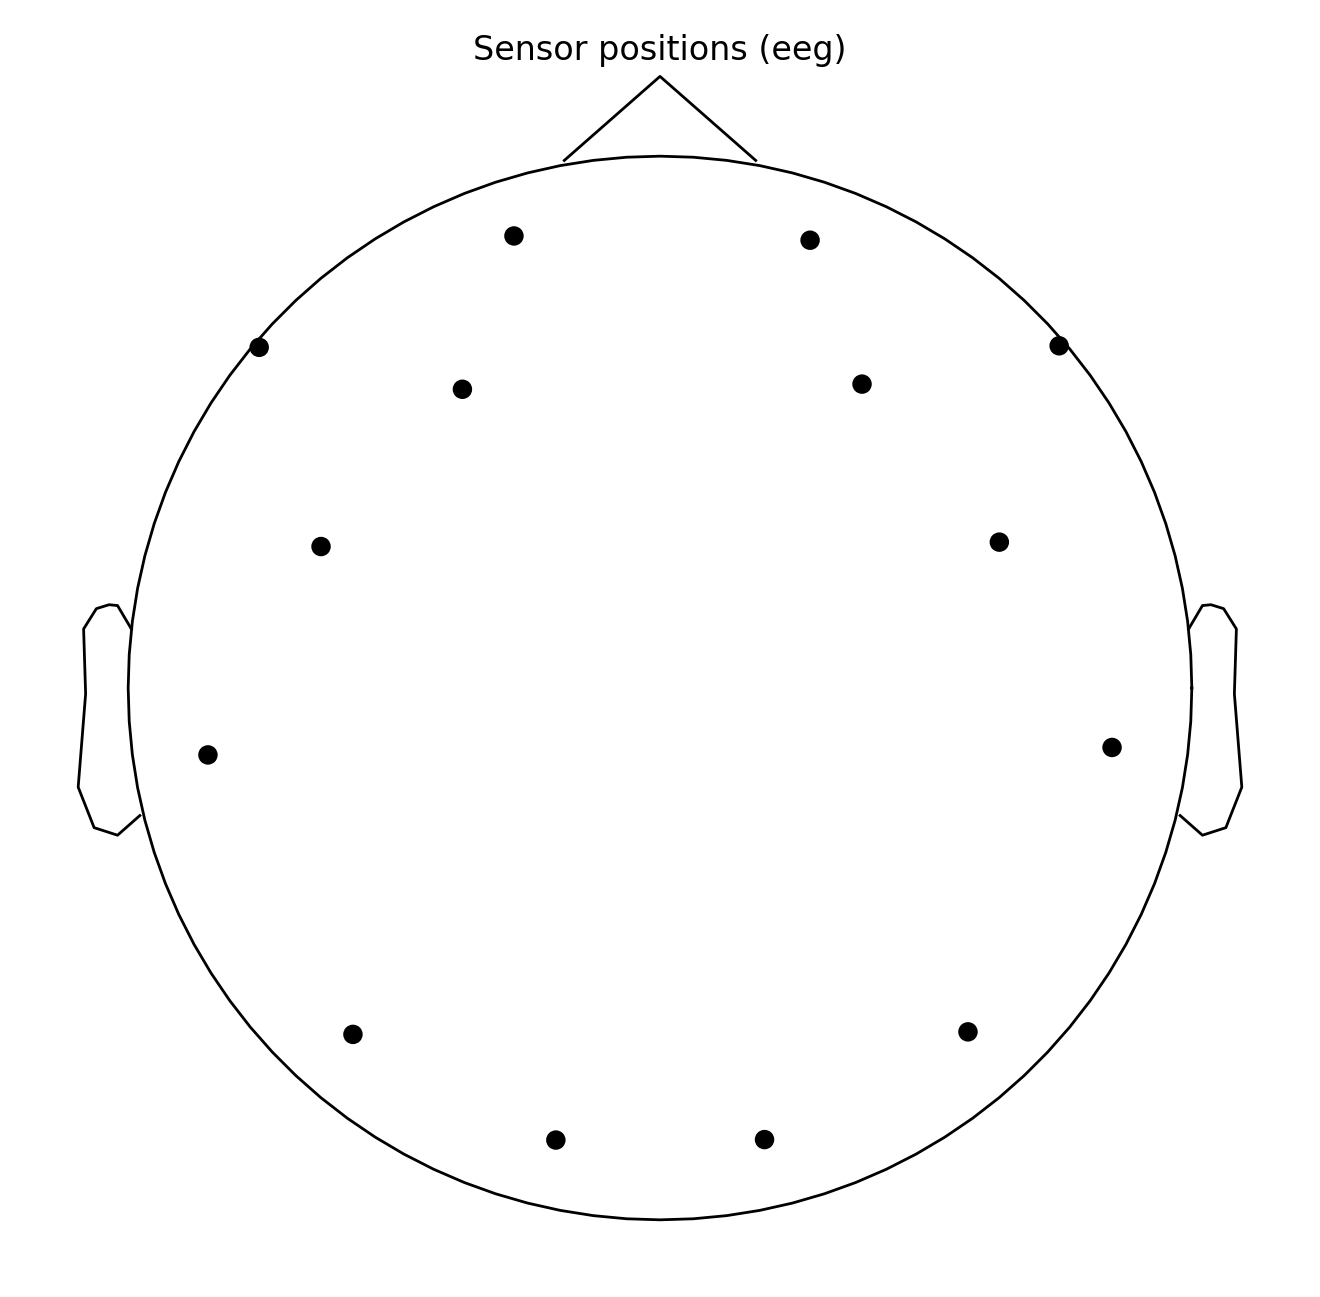

In [5]:
raw.set_montage(mne.channels.read_montage('standard_1020'))
#raw.set_montage(mne.channels.make_standard_montage('standard_1020'))
raw.plot_sensors()

In [6]:
ica_ = ICA(n_components=5, random_state=97)
ica_.fit(raw)
ica_.plot_sources(raw)
ica_.plot_components()

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components
Fitting ICA took 0.2s.


[<Figure size 1500x500 with 5 Axes>]

Transforming to ICA space (5 components)
Zeroing out 2 ICA components


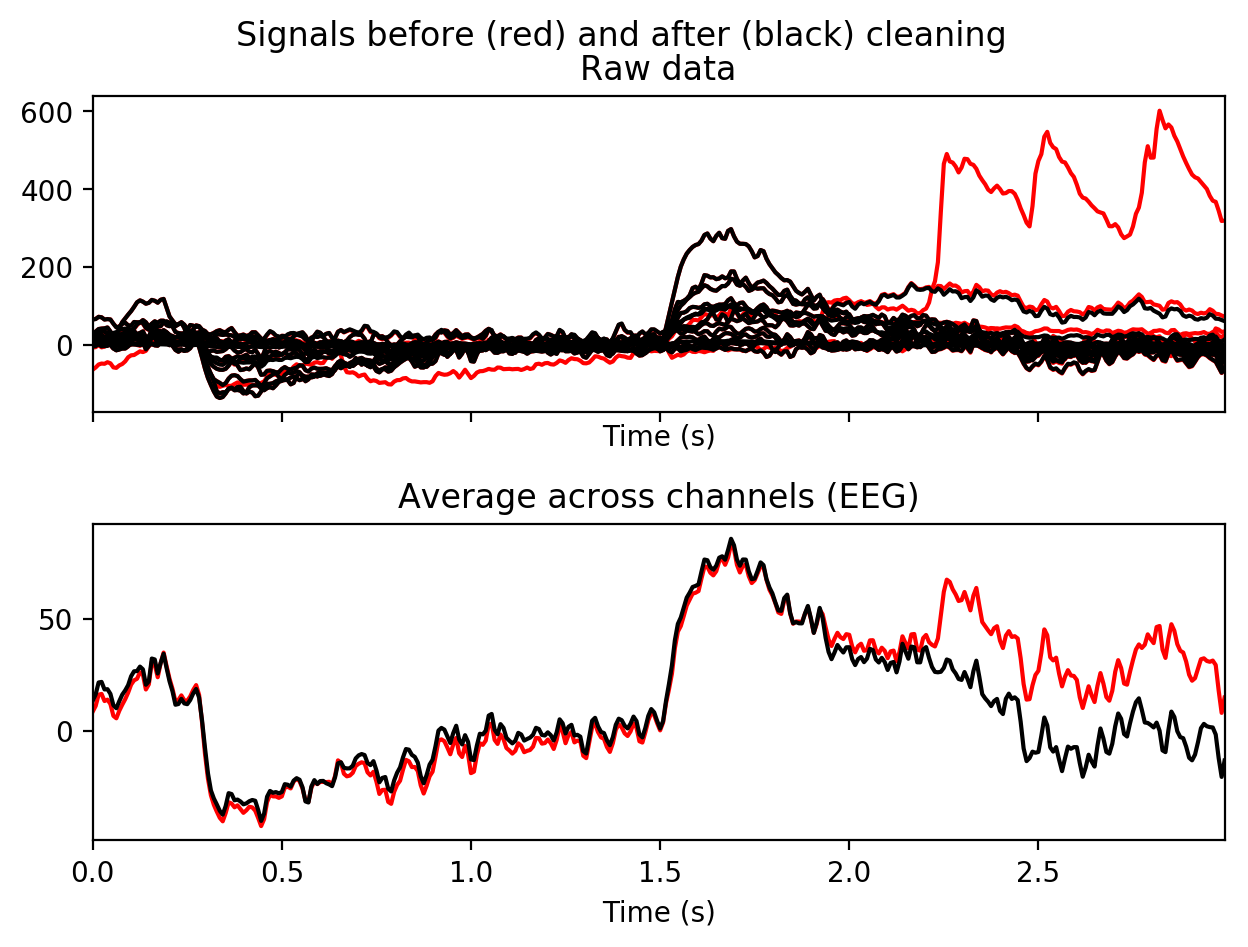

In [7]:
ica_.plot_overlay(raw, exclude=[0, 1], picks='eeg')

In [ ]:
raw_eog_free.plot(n_channels= 1)

In [8]:
ica_.exclude = [0, 1]
raw_eog_free = raw.copy()
ica_.apply(raw_eog_free)

events = mne.make_fixed_length_events(raw_eog_free, duration=1.)

tmin = 0.         # pre stimulis interval (in seconds) #
tmax = 1.          # post stimulus interval #

# artifact rejection criteria
reject = dict(eeg=100) # +/- 100µT

# baseline correction
baseline = (None, 1.0)

# do the actual epoching processes
epochs = mne.Epochs(raw_eog_free, events = events, tmin = tmin, tmax = tmax, proj = False,
                    baseline=baseline, preload = True,
                    reject=reject)

Transforming to ICA space (5 components)
Zeroing out 2 ICA components
125 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Loading data for 125 events and 129 original time points ...
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['AF3', 'F3', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['AF3', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['T8', 'F8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8', 'F4']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['O2', 'F4']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['O2', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8

In [9]:
epochs_data = epochs.get_data()
epochs_data.shape

(34, 14, 129)

In [14]:
# EEG channels:
# [1:'AF3', 2:'F7', 3:'F3', 4:'FC5', 
#  5:'T7', 6:'P7', 7:'O1', 8:'O2',
#  9:'P8', 10:'T8', 11:'FC6', 12:'F4',
#  13:'F8', 14:'AF4']

M1 = epochs_data[:, 2,:]
M2 = epochs_data[:, 11,:]

sampling_frequency = 128.0

Sxx1, f, t = average_FFT_spectrum(M1, sampling_frequency)
Sxx2, f, t = average_FFT_spectrum(M2, sampling_frequency)

plt.plot(f,10*np.log10(np.mean(Sxx1,0)), 'r')
plt.plot(f,10*np.log10(np.mean(Sxx2,0)), 'b')
plt.xlim([1, 40])
plt.ylim([-10, 50])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [ mV^2/Hz]')

Text(0, 0.5, 'Power [ mV^2/Hz]')